In [1]:
%load_ext autoreload
%autoreload 2
import astropy.units as u
import astropy.constants as const
from astroduet.bbmag import bb_abmag_fluence, bb_abmag, gettempbb
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import astroduet.config as config
from astroduet.background import background_pixel_rate

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [12,9]

In [3]:
# Telescope setup, just used for bandpass here
duet = config.Telescope()
duet.info()
bandone=duet.bandpass1
bandtwo = duet.bandpass2

-----
        DUET Telescope State: minimum_mass
        Physical Entrance Pupil: 26.0 cm
        Effective EPD: 24.5 cm
        Effective Area: 471.43524757931834 cm2
        
        Pixel size: 6.559999999999999 arcsec
        Pointing RMS: 2.5 arcsec
        Effective PSF FWHM: 11.5 arcsec
        N_eff: 8.093811494551119

        Band 1: {'eff_wave': <Quantity 198.63858525 nm>, 'eff_width': <Quantity 31.00790249 nm>}
        Bandpass 1: [183.13463401 214.1425365 ] nm
        Band 2: {'eff_wave': <Quantity 280.34471808 nm>, 'eff_width': <Quantity 41.64586798 nm>}
        Bandpass 2: [259.5217841  301.16765207] nm

        Dark current: 0.0014 ph / s
        Read noise (RMS per read): 4
        -----
        


In [4]:
# Blackbody settings
bbtab = Table([[1.e4, 2.e4, 5.e4, 1.e5, 2.e5]*u.K,np.zeros(5),np.zeros(5)], names=('temp','mag_D1','mag_D2'))
snr = np.arange(5,100)
stat_err = 2.5*np.log10(1.+1./snr)
sys_err = [0.05,0.1,0.2] # Random guess...

In [5]:
# Get blackbody magnitudes (scale is random)
for i, temp in enumerate(bbtab['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab['mag_D1'][i], bbtab['mag_D2'][i] = mag1, mag2

In [6]:
# Fit blackbody temperatures:
bbtemps = np.zeros([len(sys_err),len(bbtab['temp']),len(snr),2])*u.K
for k, syserr in enumerate(sys_err):
    for i,temp in enumerate(bbtab['temp']):
        for j,staterr in enumerate(stat_err):
            fittemp, fittemperr = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=bbtab['mag_D1'][i]*u.ABmag, magtwo=bbtab['mag_D2'][i]*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag, bbtemp_init=temp)
            bbtemps[k,i,j] = fittemp, fittemperr

In [7]:
# DUET colors as function of temperature
bbtab_large = Table([np.geomspace(5e3,30e3,num=50)*u.K,np.zeros(50),
                     np.zeros(50),np.zeros(50), np.zeros(50), np.zeros(50)],
                    names=('temp','mag_D1','mag_D2','deltamag', 'fit_temp', 'fit_err'))
for i, temp in enumerate(bbtab_large['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab_large['mag_D1'][i], bbtab_large['mag_D2'][i], bbtab_large['deltamag'][i] = mag1, mag2, mag1-mag2

In [20]:
# DUET colors as function of temperature
staterr = stat_err[6]
staterr = 0.1
sys_err = 0.1
bbtab_large = Table([np.geomspace(5e3,30e3,num=50)*u.K,np.zeros(50),
                     np.zeros(50),np.zeros(50), np.zeros(50), np.zeros(50)],
                    names=('temp','mag_D1','mag_D2','deltamag', 'fit_temp', 'fit_err'))

for i, temp in enumerate(bbtab_large['temp'].quantity):

    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=15*u.ABmag, val=True)

    fit_temp, fit_err = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=mag1*u.ABmag, magtwo=mag2*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        bbtemp_init=temp.value, diag=True)
    print(fit_temp, fit_err, fit_err / fit_temp)
    bbtab_large['fit_temp'][i] = fit_temp.value
    bbtab_large['fit_err'][i] = fit_err.value
    


Fit blackbody to ABmags in two bands
Blackbody temperature: 5064.8534475791685 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.420539582770894 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 12.017388667837292 mag(AB)
ABmag error band two: 0.223606797749979 mag(AB)
Flux density band one: 1.872740673844921e-14
Flux density band two: 2.1601329406428735e-13
Flux density error band one: 4.282791597823895e-15
Flux density error band two: 4.9400321878917104e-14
Fitted blackbody temperature: 5064.8534475791685 K
Fitted blackbody temperature error: 393.0490969813525 K

5064.8534475791685 K 393.0490969813525 K 0.0776032517128836

Fit blackbody to ABmags in two bands
Blackbody temperature: 5248.798102215703 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.389676780750387 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 12.145098338072941 mag


Fit blackbody to ABmags in two bands
Blackbody temperature: 7784.357380413388 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.158555255151459 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 13.335001603665015 mag(AB)
ABmag error band two: 0.223606797749979 mag(AB)
Flux density band one: 2.3838085549766013e-14
Flux density band two: 6.418526008444156e-14
Flux density error band one: 5.451558452625316e-15
Flux density error band two: 1.467859893433121e-14
Fitted blackbody temperature: 7784.357380413388 K
Fitted blackbody temperature error: 931.1774438546604 K

7784.357380413388 K 931.1774438546604 K 0.11962162043043434

Fit blackbody to ABmags in two bands
Blackbody temperature: 8069.490880289284 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.14534532998958 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 13.42547826158615 mag(AB)



Fit blackbody to ABmags in two bands
Blackbody temperature: 12003.185565514228 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.053396798357122 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 14.253513672851614 mag(AB)
ABmag error band two: 0.223606797749979 mag(AB)
Flux density band one: 2.626242086300463e-14
Flux density band two: 2.7544219948010734e-14
Flux density error band one: 6.0059824075730625e-15
Flux density error band two: 6.299118474303095e-15
Fitted blackbody temperature: 12003.185565514228 K
Fitted blackbody temperature error: 2266.3309635904757 K

12003.185565514228 K 2266.3309635904757 K 0.18881079120377522

Fit blackbody to ABmags in two bands
Blackbody temperature: 12445.805196567717 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.04863791196066 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 14.31477112079309 m

Flux density error band two: 3.613025092220932e-15
Fitted blackbody temperature: 18556.02225472434 K
Fitted blackbody temperature error: 5813.6869198924915 K

18556.02225472434 K 5813.6869198924915 K 0.313304588671332

Fit blackbody to ABmags in two bands
Blackbody temperature: 19243.955294195355 K
Band one: [183.13463401 214.1425365 ] nm
Band two: [259.5217841  301.16765207] nm
ABmag band one: 15.017103216238295 mag(AB)
ABmag error band one: 0.223606797749979 mag(AB)
ABmag band two: 14.89559821835503 mag(AB)
ABmag error band two: 0.223606797749979 mag(AB)
Flux density band one: 2.7155148968265212e-14
Flux density band two: 1.5247430395040892e-14
Flux density error band one: 6.2101413966818705e-15
Flux density error band two: 3.4869519147151996e-15
Fitted blackbody temperature: 19243.955294195355 K
Fitted blackbody temperature error: 6304.182099293162 K

19243.955294195355 K 6304.182099293162 K 0.3275928468403126

Fit blackbody to ABmags in two bands
Blackbody temperature: 19957.683669

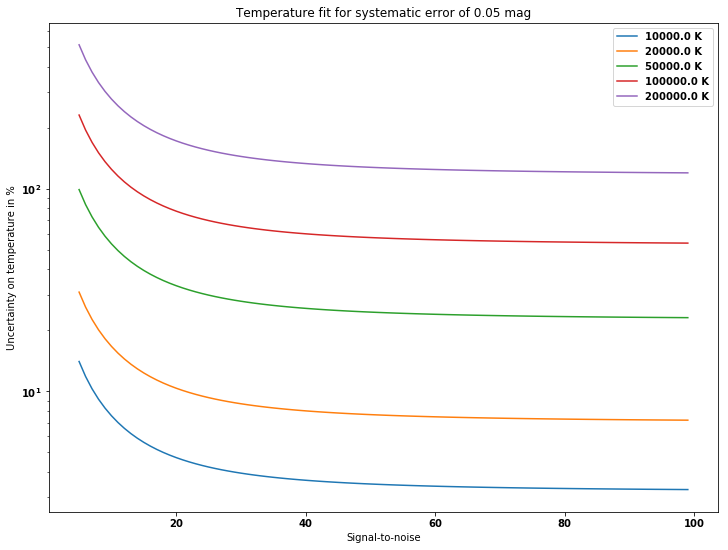

In [9]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[0,i,:,1]/bbtemps[0,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Uncertainty on temperature in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.05 mag')
plt.show()

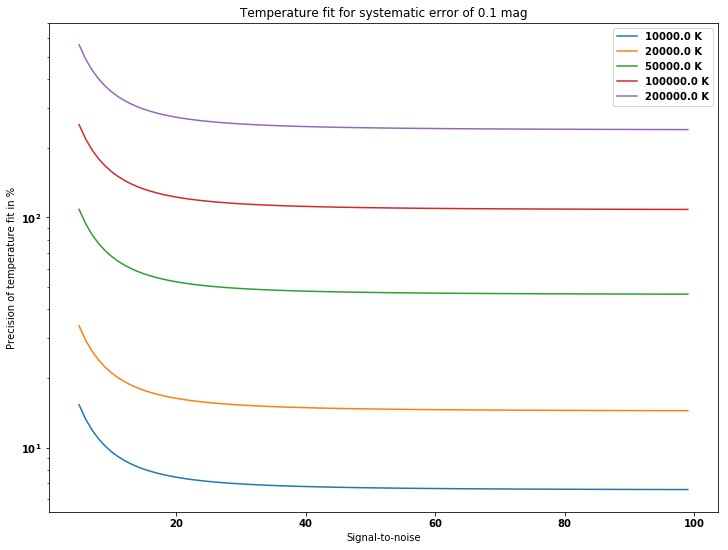

In [10]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[1,i,:,1]/bbtemps[1,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.1 mag')
plt.show()

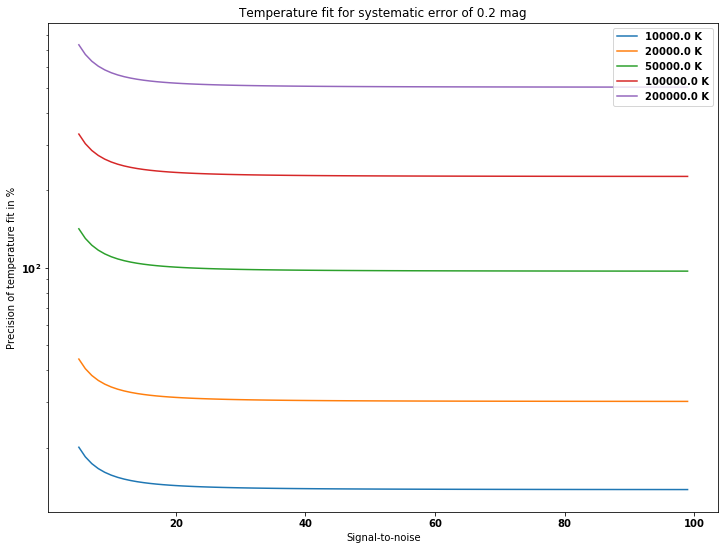

In [11]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[2,i,:,1]/bbtemps[2,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

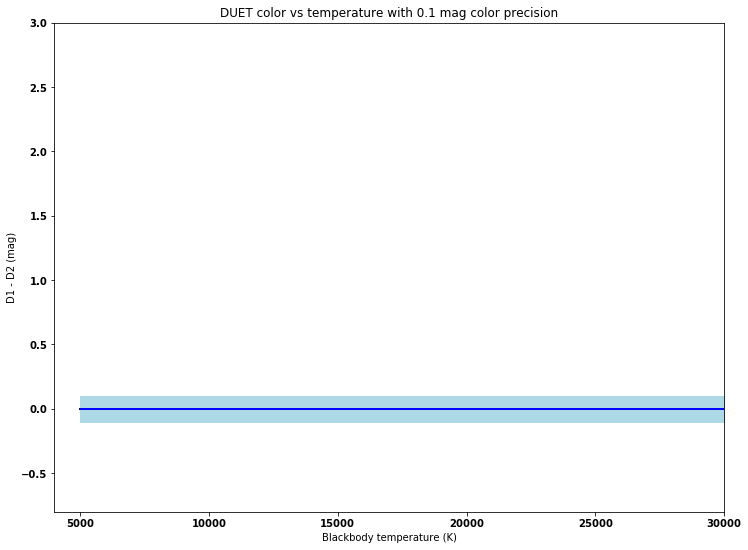

In [12]:
plt.fill_between(bbtab_large['temp'], bbtab_large['deltamag']-0.1, bbtab_large['deltamag']+0.1, color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['deltamag'],linewidth=2, color='blue')

plt.xlabel('Blackbody temperature (K)')
plt.ylabel('D1 - D2 (mag)')
plt.ylim(-0.8,3)
plt.xlim(4e3,30e3)
#plt.xscale('log')
plt.title('DUET color vs temperature with 0.1 mag color precision')
plt.show()

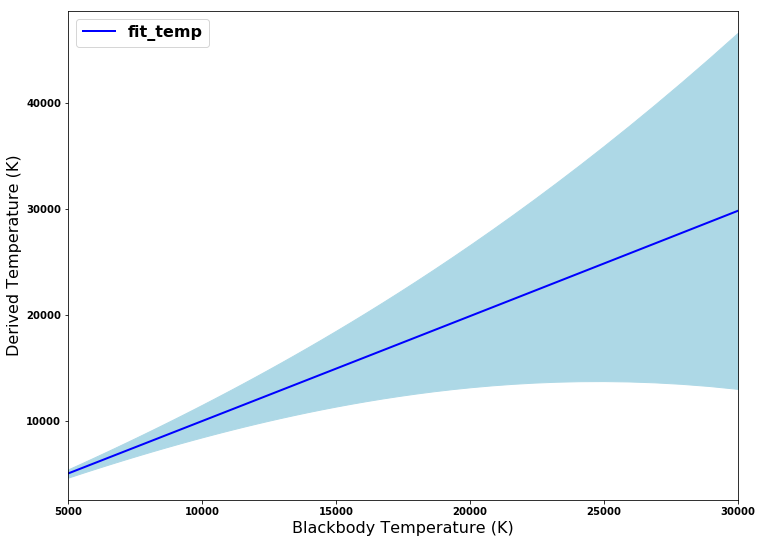

In [13]:
plt.fill_between(bbtab_large['temp'], bbtab_large['fit_temp']-bbtab_large['fit_err'],
                 bbtab_large['fit_temp']+bbtab_large['fit_err'], color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['fit_temp'],linewidth=2, color='blue')


plt.xlim(5e3,30e3)
#plt.yscale('log')
plt.ylabel('Derived Temperature (K)', fontsize=16)
plt.xlabel('Blackbody Temperature (K)', fontsize=16)
plt.legend(fontsize=16,loc=2)
#plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

Text(0.5, 0, 'Blackbody Temperature (K)')

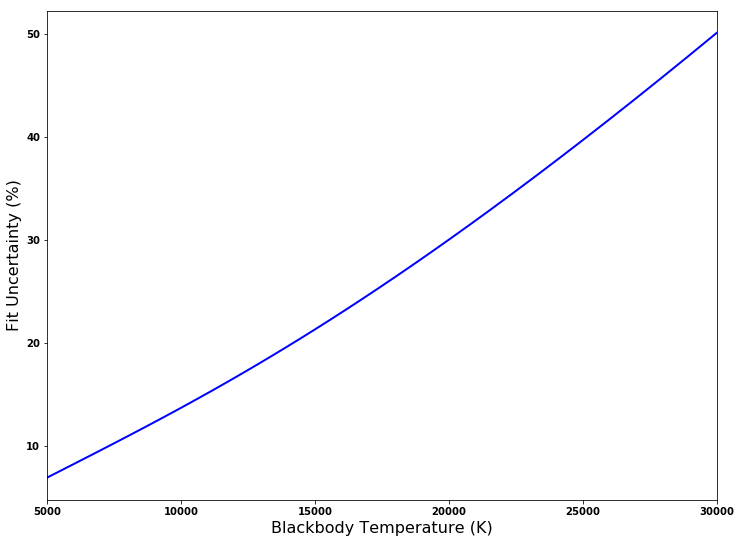

In [19]:
# plt.fill_between(bbtab_large['temp'], bbtab_large['fit_temp']-0.5*bbtab_large['fit_err'],
#                  bbtab_large['fit_temp']+0.5*bbtab_large['fit_err'], color='lightblue')
frac_err = 100*(bbtab_large['temp'] - bbtab_large['fit_temp']) / bbtab_large['temp']

plt.plot(bbtab_large['temp'],100*bbtab_large['fit_err'] / bbtab_large['temp'],linewidth=2, color='blue')


plt.xlim(5e3,30e3)
#plt.yscale('log')
plt.ylabel('Fit Uncertainty (%)', fontsize=16)
plt.xlabel('Blackbody Temperature (K)', fontsize=16)
#plt.legend(fontsize=16,loc=2)